In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import torch
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# read data

In [49]:
df=pd.read_csv('/kaggle/input/aqi-india/data.csv' ,encoding='cp1252')

/tmp/ipykernel_146/208602420.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/kaggle/input/aqi-india/data.csv' ,encoding='cp1252')


# data summary

In [50]:
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


- The dataset contains the following features :
    - stn_code : Station code. A code is given to each station that recorded the data.
    - sampling_date: The date when the data was recorded.
    - state: It represents the states whose air quality data is measured.
    - location: It represents the city whose air quality data is measured.
    - agency: Name of the agency that measured the data.
    - type: The type of area where the measurement was made.
    - so2: The amount of Sulphur Dioxide measured.
    - no2: The amount of Nitrogen Dioxide measured
    - rspm: Respirable Suspended Particulate Matter measured.
    - spm: Suspended Particulate Matter measured.
    - location_monitoring_station: It indicates the location of the monitoring area.
    - pm2_5: It represents the value of particulate matter measured.
    - date: It represents the date of recording (It is a cleaner version of ‘sampling_date’ feature)
- Overall, the data includes five types of pollutants: so2, No2, rspm and SPM.

In [51]:
df.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [53]:
df.shape

(435742, 13)

# clean data

- overall, base on the data, I observe that columns `stn_code,sampling_date,location_monitoring_station ,agency` don't significantly affect air quality. Therefore, I will remove them to simplify the data and avoid clutter.

In [54]:
df.drop(columns=['stn_code','sampling_date','location_monitoring_station','agency'],axis=1,inplace=True)

In [55]:
df

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,NaN,NaN,NaN,1990-03-01
...,...,...,...,...,...,...,...,...,...
435737,West Bengal,ULUBERIA,RIRUO,22.0,50.0,143.0,NaN,NaN,2015-12-24
435738,West Bengal,ULUBERIA,RIRUO,20.0,46.0,171.0,NaN,NaN,2015-12-29
435739,andaman-and-nicobar-islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435740,Lakshadweep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df=df.drop_duplicates()
df.shape


(434607, 9)

In [57]:
df.shape

(434607, 9)

## find missing data

In [58]:
df.select_dtypes(include=['float64', 'int64']).columns


Index(['so2', 'no2', 'rspm', 'spm', 'pm2_5'], dtype='object')

In [59]:
df.select_dtypes(include=['object']).columns

Index(['state', 'location', 'type', 'date'], dtype='object')

In [60]:
#count the number
df.isna().sum()

state            0
location         3
type          5302
so2          34522
no2          16138
rspm         39959
spm         236583
pm2_5       425307
date             7
dtype: int64

- Here, we need to fill the mean value into columns with numerical data types float64, int64
-  and fill the mode into columns with categorical data types object

In [61]:
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [62]:
group_state = df.groupby('state') # group by state

In [63]:
def fillnan_column(column):
    return column.fillna(column.mean()) 

- here use transform to perform a transformation on each group, but the result will remain the size of the original column.
It ensures that each value in the group is replaced or calculated based on its respective group.

In [64]:
df['rspm']=group_state['rspm'].transform(fillnan_column) 
df['so2']=group_state['so2'].transform(fillnan_column)
df['no2']=group_state['no2'].transform(fillnan_column)
df['spm']=group_state['spm'].transform(fillnan_column)
df['pm2_5']=group_state['pm2_5'].transform(fillnan_column)

/tmp/ipykernel_146/1033289297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rspm']=group_state['rspm'].transform(fillnan_column)
/tmp/ipykernel_146/1033289297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['so2']=group_state['so2'].transform(fillnan_column)
/tmp/ipykernel_146/1033289297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [65]:
df.isna().sum()

state            0
location         3
type          5302
so2              3
no2              3
rspm             3
spm           4069
pm2_5       311120
date             7
dtype: int64

In [66]:
df.describe()

,so2,no2,rspm,spm,pm2_5
count,434604.000000,434604.000000,434604.000000,430538.000000,123487.000000
mean,10.592373,25.680799,109.737692,215.275688,48.331668
std,10.857399,18.267523,72.553928,117.478432,21.461360
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,4.800000,14.000000,59.000000,142.000000,30.719599
50%,8.000000,21.800000,93.000000,205.259881,42.204529
75%,13.000000,32.000000,142.011286,248.666667,64.890625
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


## visualization for state with highest pollutanst

### group `state` with inex so2

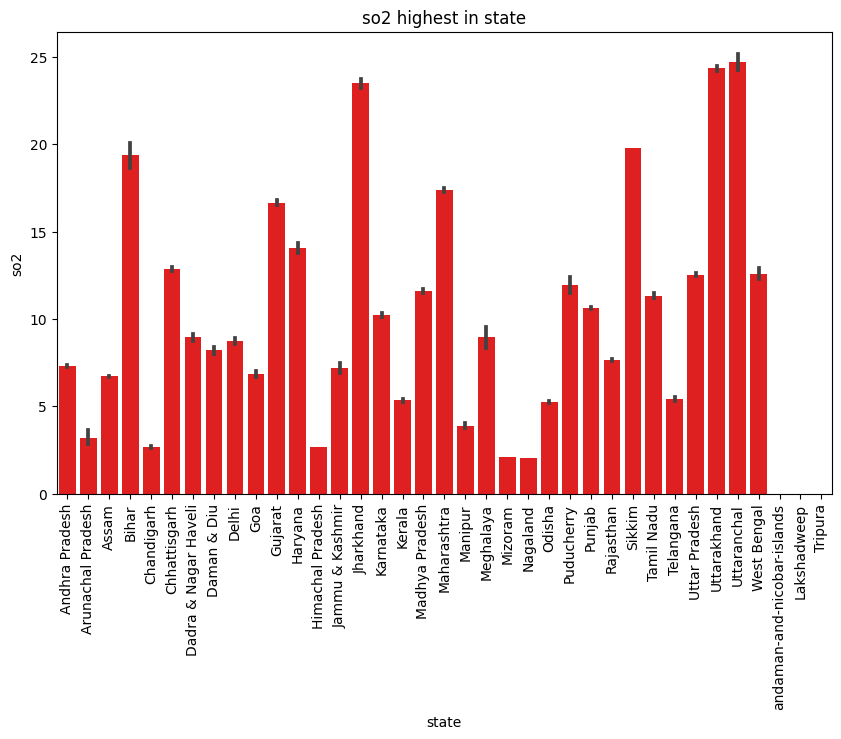

In [67]:
a=df[['so2','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['so2'],data=a,color='red')
plt.title('so2 highest in state')
plt.xticks(rotation=90)
plt.show()

### group `state` with inex no2

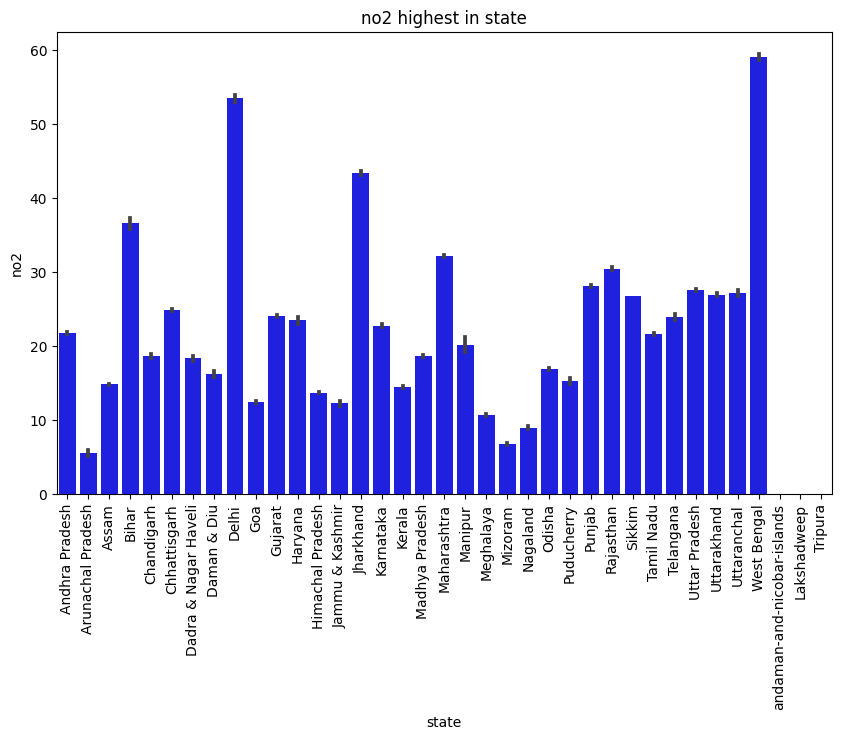

In [68]:
a=df[['no2','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['no2'],data=a,color='blue')
plt.title('no2 highest in state')
plt.xticks(rotation=90)
plt.show()

### group `state` with inex rspm

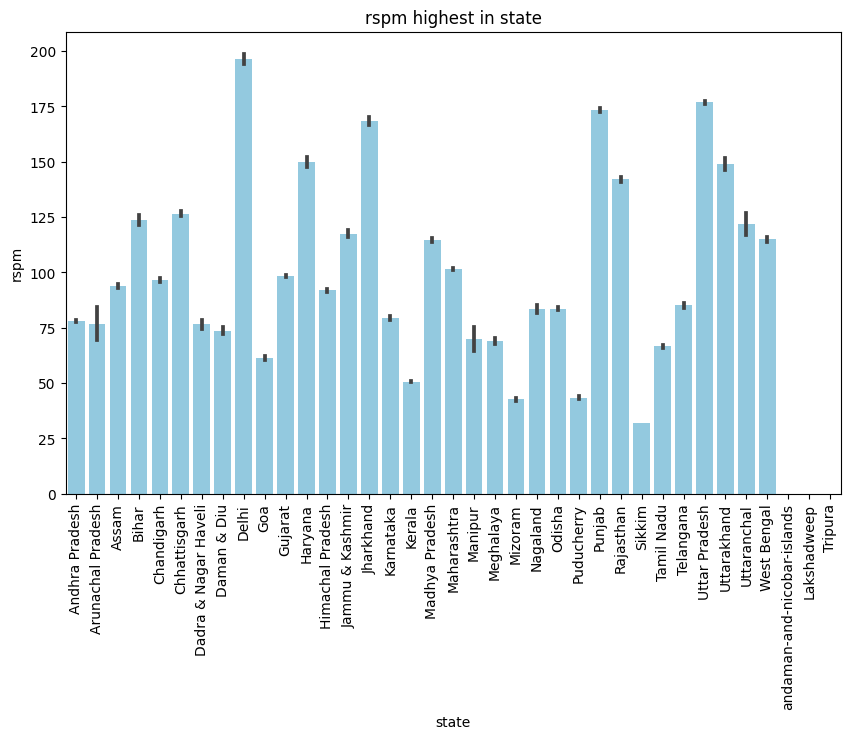

In [69]:
a=df[['rspm','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['rspm'],data=a,color='skyblue')
plt.title('rspm highest in state')
plt.xticks(rotation=90)
plt.show()

### group `state` with inex spm

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


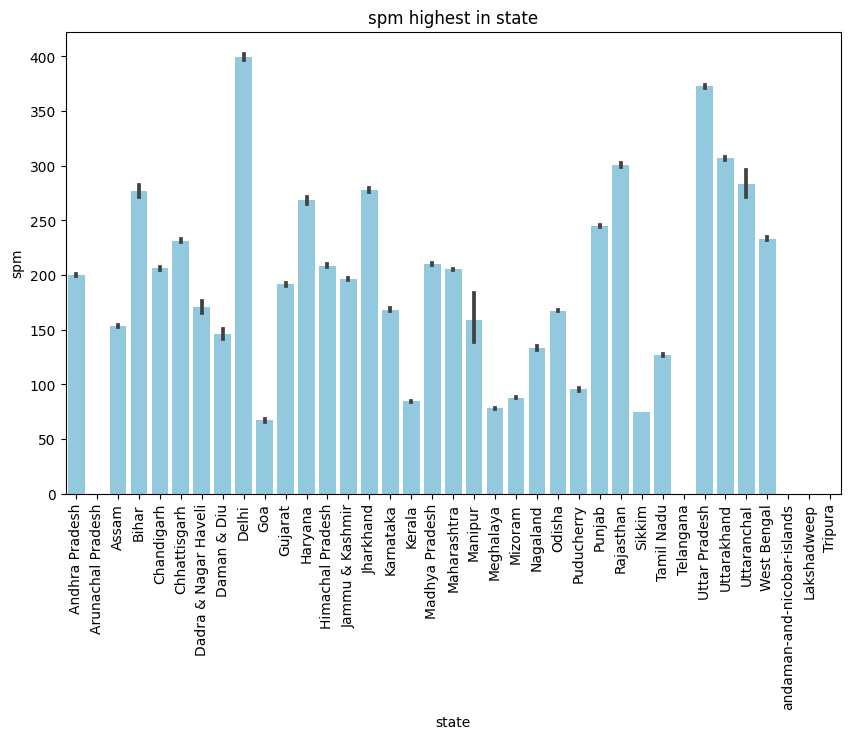

In [70]:
a=df[['spm','state']]
plt.figure(figsize=(10, 6))
sns.barplot(x=a['state'],y=a['spm'],data=a,color='skyblue')
plt.title('spm highest in state')
plt.xticks(rotation=90)
plt.show()

# Calculate the equation

- The AQI (Air Quality Index) is an indicator used to evaluate air quality on a daily basis. The AQI tells you how clean or polluted the air is and how it affects human health. The AQI index is calculated to help warn of possible negative effects on health when the air becomes polluted.

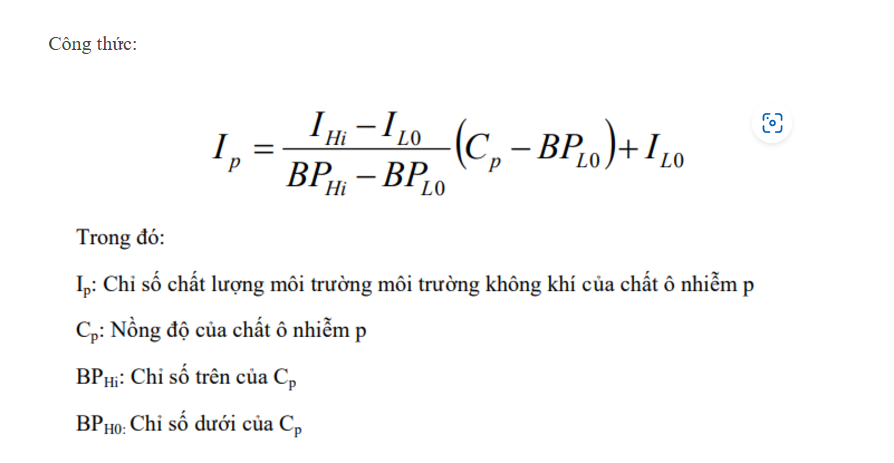
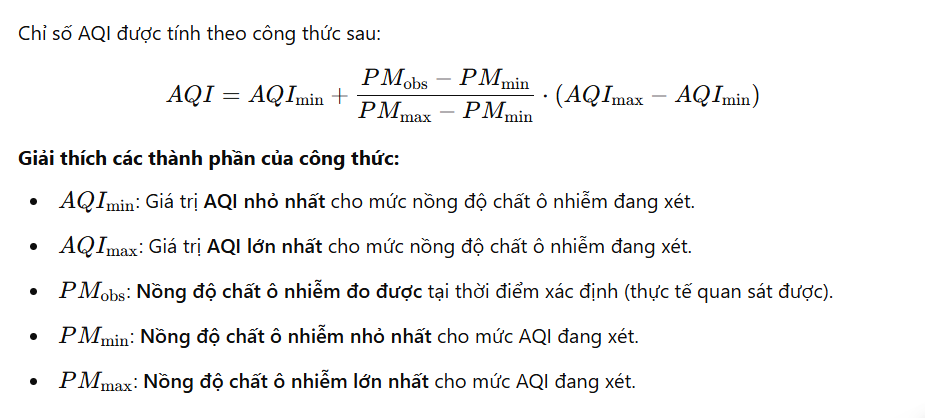

- This formula allows the determination of the AQI value based on the concentration of the pollutant being measured. The main pollutants considered include ground-level ozone, PM fine dust (PM2.5, PM10), carbon monoxide, sulfur dioxide, and nitrogen dioxide. The AQI typically ranges from 0 to 500, with each value representing a different degree of impact on health.
- 
The purpose of AQI is to provide an easy-to-understand parameter for people, helping them to be aware of pollution and health effects, so that they can take appropriate measures to protect themselves and their families from the effects of polluted air.

In [71]:
def cal_SOi(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    elif (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    elif (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    elif (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/420)
    elif (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    elif (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si
df['SOi']=df['so2'].apply(cal_SOi)
dfa= df[['so2','SOi']]
dfa.head()

/tmp/ipykernel_146/3093687686.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SOi']=df['so2'].apply(cal_SOi)


,so2,SOi
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [72]:
def cal_Noi(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-40)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
df['Noi']=df['no2'].apply(cal_Noi)
dfa= df[['no2','Noi']]
dfa.head()

/tmp/ipykernel_146/3616410374.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Noi']=df['no2'].apply(cal_Noi)


,no2,Noi
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [73]:
def cal_RSPMi(rspm):
    rpi=0
    if(rspm<=100):
     rpi = rspm
    elif(rspm>=101 and rspm<=150):
     rpi= 101+(rspm-101)*((200-101)/(150-101))
    elif(rspm>=151 and rspm<=350):
     ni= 201+(rspm-151)*((300-201)/(350-151))
    elif(rspm>=351 and rspm<=420):
     ni= 301+(rspm-351)*((400-301)/(420-351))
    elif(rspm>420):
     ni= 401+(rspm-420)*((500-401)/(420-351))
    return rpi
df['RSPMi']=df['rspm'].apply(cal_RSPMi)
dfa= df[['rspm','RSPMi']]
dfa.head()

/tmp/ipykernel_146/2706614480.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSPMi']=df['rspm'].apply(cal_RSPMi)


,rspm,RSPMi
0,78.246833,78.246833
1,78.246833,78.246833
2,78.246833,78.246833
3,78.246833,78.246833
4,78.246833,78.246833


In [74]:
def cal_SPMi(spm):
    spi=0
    if(spm<=50):
     spi=spm*50/50
    elif(spm>50 and spm<=100):
     spi=50+(spm-50)*(50/50)
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)*(100/100)
    elif(spm>350 and spm<=430):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/430)
    return spi
   
df['SPMi']=df['spm'].apply(cal_SPMi)
dfa= df[['spm','SPMi']]
dfa.head()

/tmp/ipykernel_146/3339458251.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SPMi']=df['spm'].apply(cal_SPMi)


,spm,SPMi
0,200.327412,166.884941
1,200.327412,166.884941
2,200.327412,166.884941
3,200.327412,166.884941
4,200.327412,166.884941


In [75]:
df.columns

Index(['state', 'location', 'type', 'so2', 'no2', 'rspm', 'spm', 'pm2_5',
       'date', 'SOi', 'Noi', 'RSPMi', 'SPMi'],
      dtype='object')

#### count AQI by index AQI_NO2,AQI_SO2,AQI_PM10,AQI_PM2.5,AQI_RSPM

In [76]:
df.iloc[:,-4:]

,SOi,Noi,RSPMi,SPMi
0,6.000,21.750,78.246833,166.884941
1,3.875,8.750,78.246833,166.884941
2,7.750,35.625,78.246833,166.884941
3,7.875,18.375,78.246833,166.884941
4,5.875,9.375,78.246833,166.884941
...,...,...,...,...
435737,27.500,62.500,185.857143,188.987339
435738,25.000,57.500,0.000000,188.987339
435739,0.000,NaN,0.000000,NaN
435740,0.000,NaN,0.000000,NaN


In [77]:
a.head()

,spm,state
0,200.327412,Andhra Pradesh
1,200.327412,Andhra Pradesh
2,200.327412,Andhra Pradesh
3,200.327412,Andhra Pradesh
4,200.327412,Andhra Pradesh


In [78]:
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,SOi,Noi,RSPMi,SPMi
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.246833,200.327412,NaN,1990-02-01,6.000,21.750,78.246833,166.884941
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.246833,200.327412,NaN,1990-02-01,3.875,8.750,78.246833,166.884941
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.246833,200.327412,NaN,1990-02-01,7.750,35.625,78.246833,166.884941
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.246833,200.327412,NaN,1990-03-01,7.875,18.375,78.246833,166.884941
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.246833,200.327412,NaN,1990-03-01,5.875,9.375,78.246833,166.884941


# the level AQI

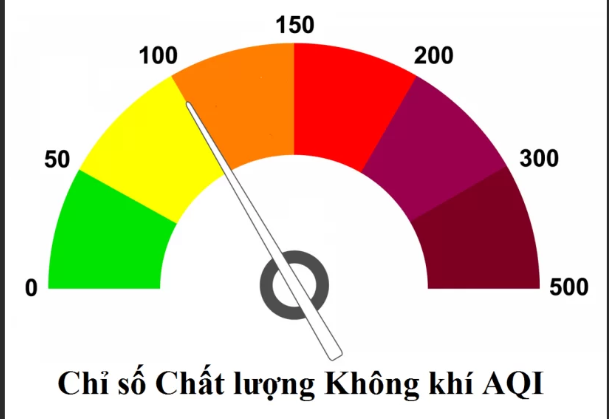
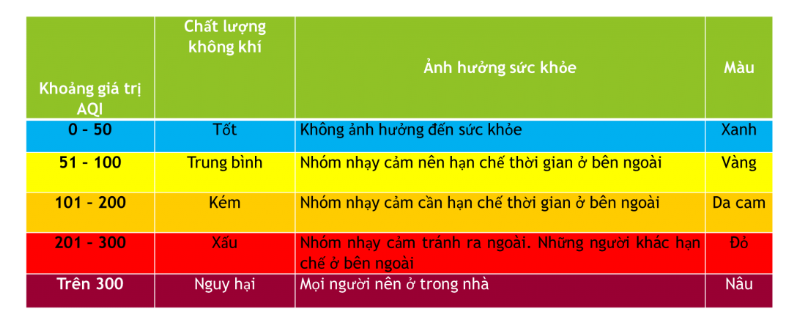

- In the image, the index shows the levels of air pollutants according to the AQI:
    - to 0 - 50: `goodd`
    - 50-100: `moderate`
    - 100 - 150: `poor`
    - 150 - 200: `unhealthy`
    - 200 - 300: `very unhealthy`
    - 300 - 500: `Hazardous`

In [79]:
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,SOi,Noi,RSPMi,SPMi
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.246833,200.327412,NaN,1990-02-01,6.000,21.750,78.246833,166.884941
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.246833,200.327412,NaN,1990-02-01,3.875,8.750,78.246833,166.884941
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.246833,200.327412,NaN,1990-02-01,7.750,35.625,78.246833,166.884941
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.246833,200.327412,NaN,1990-03-01,7.875,18.375,78.246833,166.884941
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.246833,200.327412,NaN,1990-03-01,5.875,9.375,78.246833,166.884941


In [80]:
def cal_aqi(si,ni,rspmi,spmi):
    aqi=0
    if(si>ni and si>rspmi and si>spmi):
     aqi=si
    if(ni>si and ni>rspmi and ni>spmi ):
     aqi=ni
    if(rspmi>si and rspmi>ni and rspmi>spmi ):
     aqi=rspmi
    if(spmi>si and spmi>ni and spmi>rspmi):
     aqi=spmi
    return aqi

df['AQI']=df.apply(lambda x:cal_aqi(x['SOi'],x['Noi'],x['RSPMi'],x['SPMi']),axis=1)
df.head()

/tmp/ipykernel_146/69846904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AQI']=df.apply(lambda x:cal_aqi(x['SOi'],x['Noi'],x['RSPMi'],x['SPMi']),axis=1)


,state,location,type,so2,no2,rspm,spm,pm2_5,date,SOi,Noi,RSPMi,SPMi,AQI
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.246833,200.327412,NaN,1990-02-01,6.000,21.750,78.246833,166.884941,166.884941
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.246833,200.327412,NaN,1990-02-01,3.875,8.750,78.246833,166.884941,166.884941
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.246833,200.327412,NaN,1990-02-01,7.750,35.625,78.246833,166.884941,166.884941
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.246833,200.327412,NaN,1990-03-01,7.875,18.375,78.246833,166.884941,166.884941
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.246833,200.327412,NaN,1990-03-01,5.875,9.375,78.246833,166.884941,166.884941


### Heatmap Pivot with State as Row, Year as Col, AQI as Value

/tmp/ipykernel_146/62141729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
/tmp/ipykernel_146/62141729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year # year
/tmp/ipykernel_146/62141729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

<Axes: title={'center': 'AQI by state and year'}, xlabel='year', ylabel='state'>

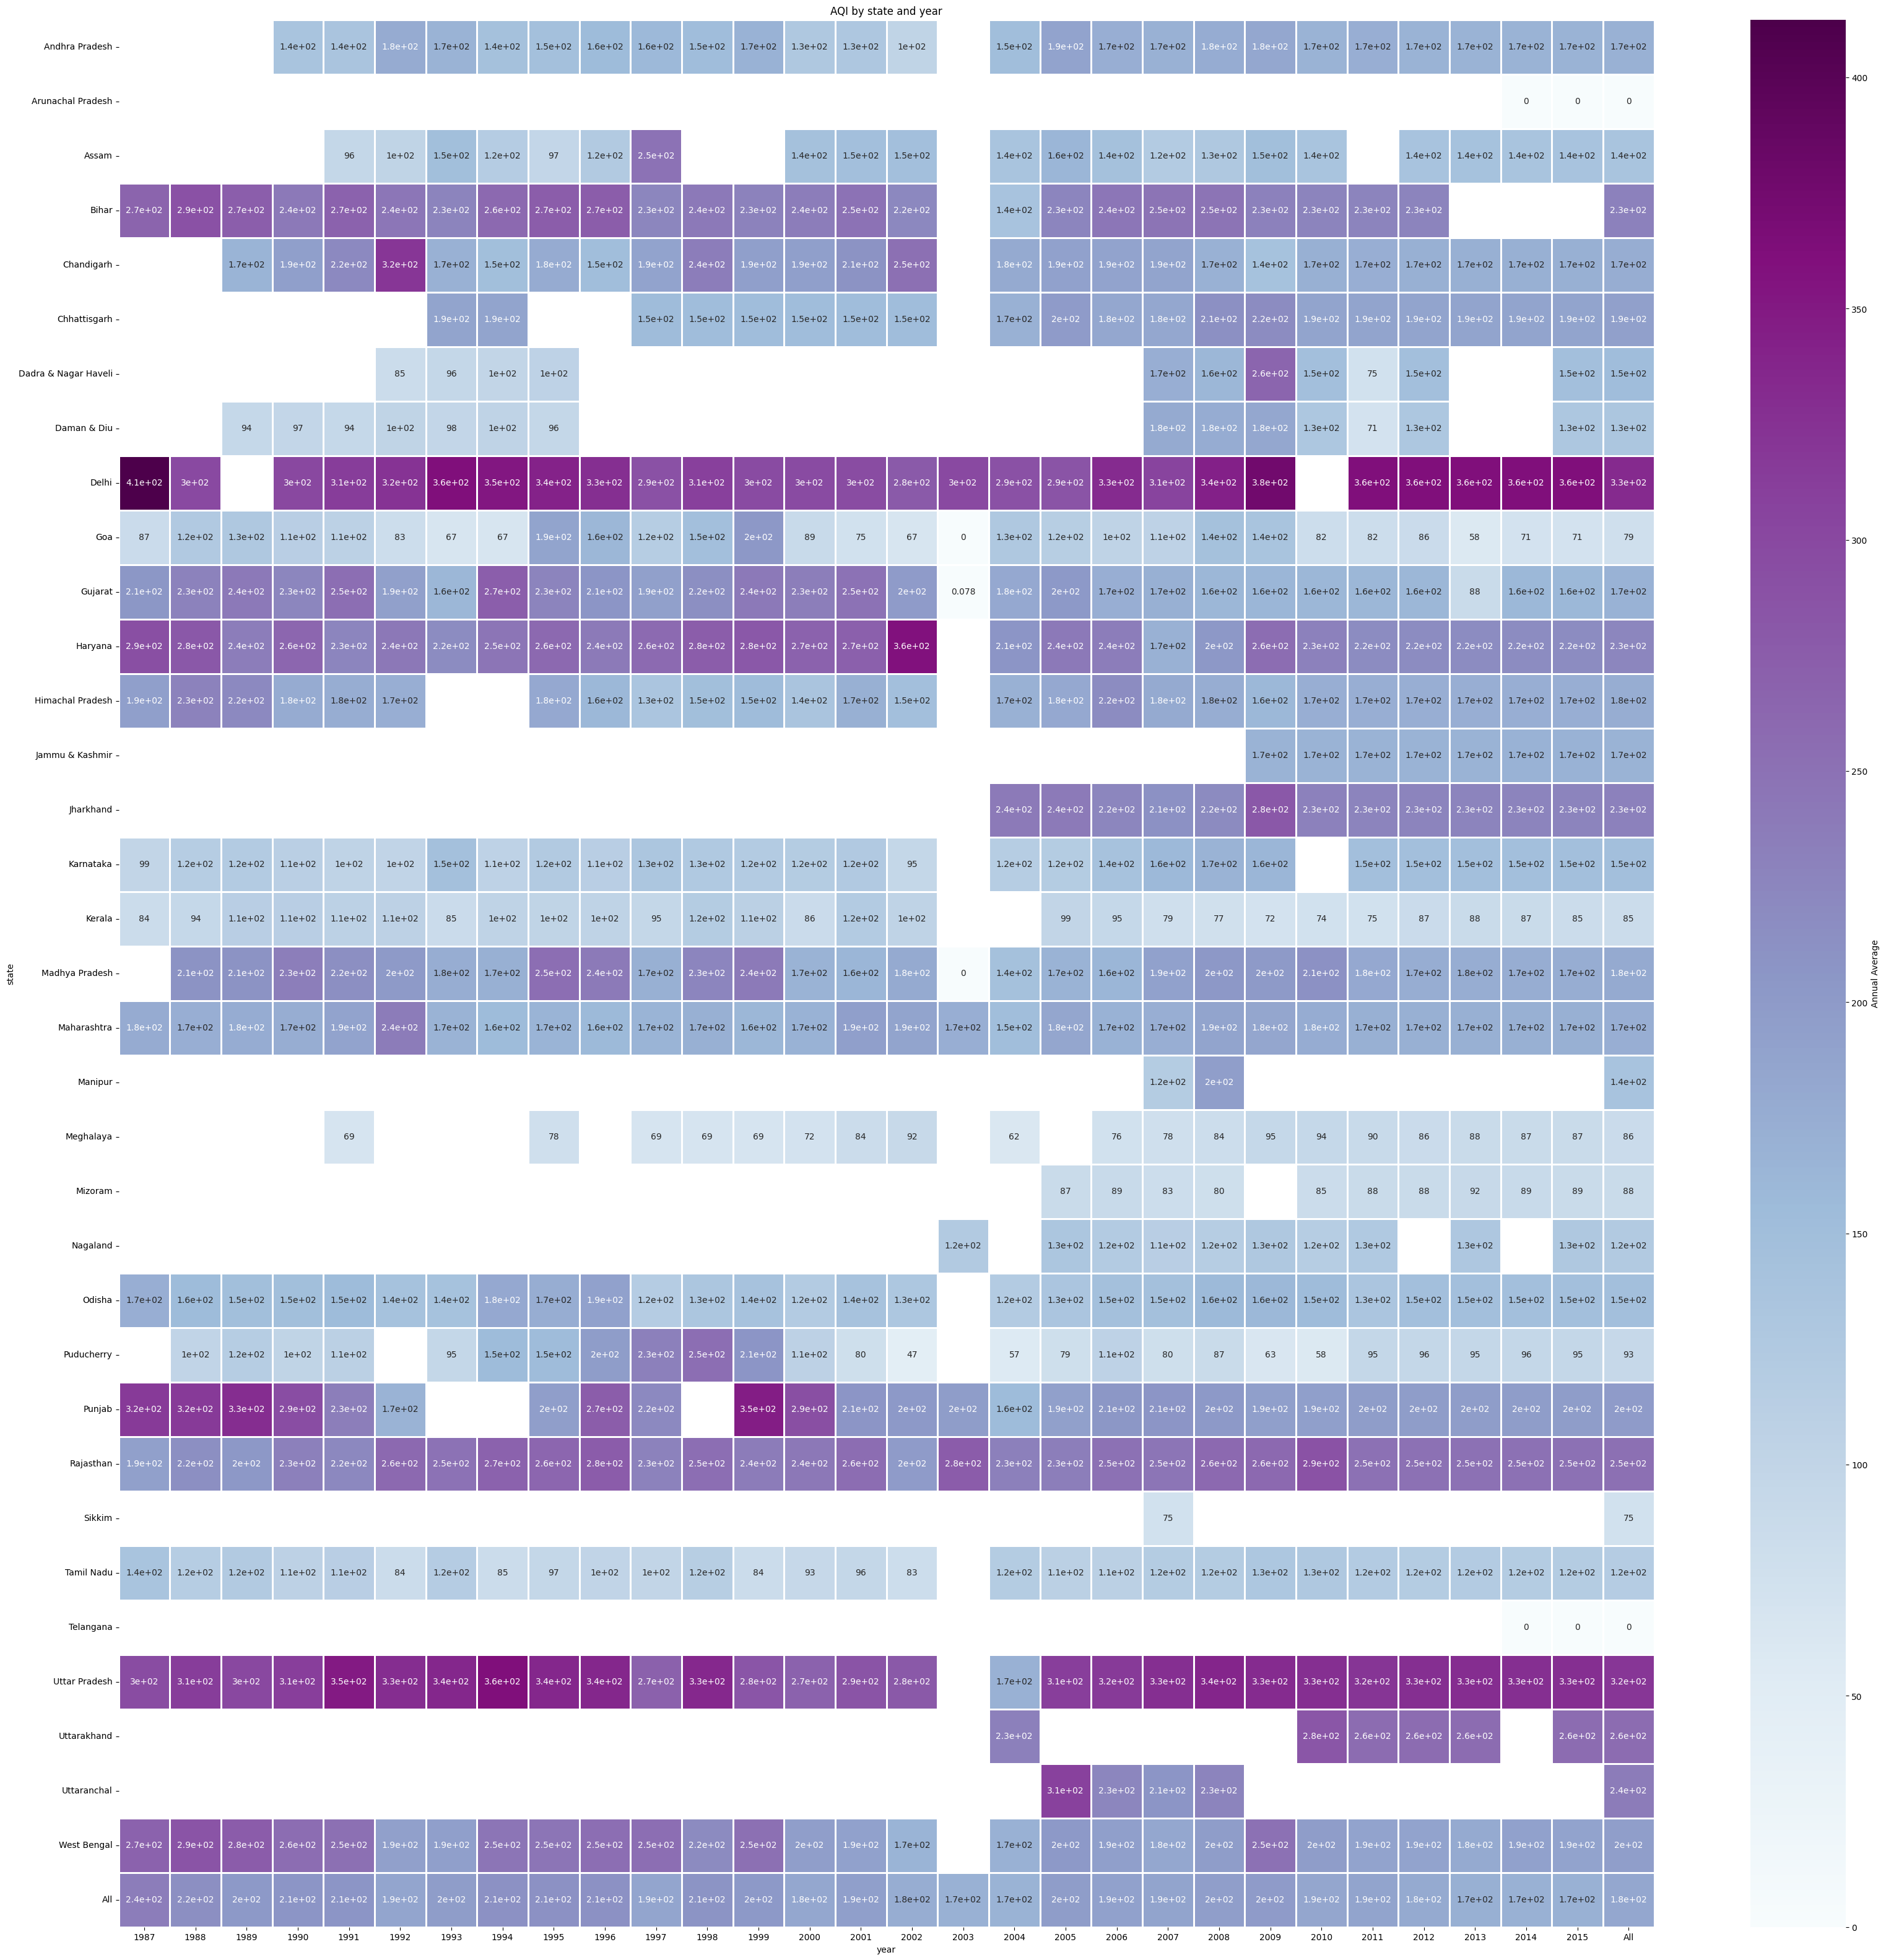

In [81]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(0.0).astype(int)
df = df[(df['year']>0)]
f, ax = plt.subplots(figsize=(40,40))
ax.set_title('{} by state and year'.format('AQI'))
sns.heatmap(df.pivot_table('AQI', index='state',
                columns=['year'],aggfunc='mean',margins=True),
                annot=True,cmap="BuPu", linewidths=.75, ax=ax,cbar_kws={'label': 'Annual Average'})

## set the level

In [82]:
def set_level(x):
    if x<=50:
        return 5
    elif x>50 and x<=100:
        return 4
    elif x>100 and x<=200:
        return 3
    elif x>200 and x<=300:
        return 2
    elif x>300 and x<=400:
        return 1
    elif x>400:
        return 0

df['level'] = df['AQI'] .apply(set_level)
df.head()

/tmp/ipykernel_146/37738920.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'] = df['AQI'] .apply(set_level)


,state,location,type,so2,no2,rspm,spm,pm2_5,date,SOi,Noi,RSPMi,SPMi,AQI,year,level
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.246833,200.327412,NaN,1990-02-01,6.000,21.750,78.246833,166.884941,166.884941,1990,3
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.246833,200.327412,NaN,1990-02-01,3.875,8.750,78.246833,166.884941,166.884941,1990,3
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.246833,200.327412,NaN,1990-02-01,7.750,35.625,78.246833,166.884941,166.884941,1990,3
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.246833,200.327412,NaN,1990-03-01,7.875,18.375,78.246833,166.884941,166.884941,1990,3
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.246833,200.327412,NaN,1990-03-01,5.875,9.375,78.246833,166.884941,166.884941,1990,3


## xử lí date

In [83]:
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,SOi,Noi,RSPMi,SPMi,AQI,year,level
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.246833,200.327412,NaN,1990-02-01,6.000,21.750,78.246833,166.884941,166.884941,1990,3
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.246833,200.327412,NaN,1990-02-01,3.875,8.750,78.246833,166.884941,166.884941,1990,3
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.246833,200.327412,NaN,1990-02-01,7.750,35.625,78.246833,166.884941,166.884941,1990,3
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.246833,200.327412,NaN,1990-03-01,7.875,18.375,78.246833,166.884941,166.884941,1990,3
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.246833,200.327412,NaN,1990-03-01,5.875,9.375,78.246833,166.884941,166.884941,1990,3


In [84]:
from statsmodels.tsa.stattools import adfuller

In [85]:
# Check stationarity of time series using ADF test
# def check_stationarity(timeseries):
#     result = adfuller(timeseries)
#     print('ADF Statistic:', result[0])
#     print('p-value:', result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))

In [86]:
# check_stationarity(df['date']).to(device)

In [87]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date') #set
# df.sort_index()

/tmp/ipykernel_146/2336968754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [88]:
df.sort_index()

,state,location,type,so2,no2,rspm,spm,pm2_5,SOi,Noi,RSPMi,SPMi,AQI,year,level
date,,,,,,,,,,,,,,,
1987-01-01,Rajasthan,Kota,Industrial,7.661019,30.421554,142.011286,102.000000,NaN,9.576274,38.026943,183.859536,101.333333,183.859536,1987,3
1987-01-01,West Bengal,Howrah,Industrial,103.400000,148.000000,115.028369,968.000000,64.890625,107.800000,168.000000,129.343032,525.116279,525.116279,1987,0
1987-01-01,West Bengal,Howrah,Industrial,26.900000,72.900000,115.028369,778.000000,64.890625,33.625000,91.125000,129.343032,480.930233,480.930233,1987,0
1987-01-01,Gujarat,Baroda,Industrial,26.700000,17.700000,98.406755,156.000000,30.719599,33.375000,22.125000,98.406755,137.333333,137.333333,1987,3
1987-01-01,Gujarat,Baroda,Residential,14.500000,9.000000,98.406755,229.000000,30.719599,18.125000,11.250000,98.406755,186.000000,186.000000,1987,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,Karnataka,Bangalore,"Residential, Rural and other Areas",2.000000,24.000000,74.000000,168.218548,NaN,2.500000,30.000000,74.000000,145.479032,145.479032,2015,3
2015-12-31,Madhya Pradesh,Ujjain,"Residential, Rural and other Areas",19.000000,22.000000,142.000000,210.066508,65.064565,23.750000,27.500000,183.836735,173.377672,183.836735,2015,3
2015-12-31,Maharashtra,Chandrapur,"Residential, Rural and other Areas",17.392806,21.000000,175.000000,205.259881,NaN,21.741008,26.250000,0.000000,170.173254,170.173254,2015,3


### slpit data to column predict

In [89]:
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,SOi,Noi,RSPMi,SPMi,AQI,year,level
date,,,,,,,,,,,,,,,
1990-02-01,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.246833,200.327412,NaN,6.000,21.750,78.246833,166.884941,166.884941,1990,3
1990-02-01,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.246833,200.327412,NaN,3.875,8.750,78.246833,166.884941,166.884941,1990,3
1990-02-01,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.246833,200.327412,NaN,7.750,35.625,78.246833,166.884941,166.884941,1990,3
1990-03-01,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.246833,200.327412,NaN,7.875,18.375,78.246833,166.884941,166.884941,1990,3
1990-03-01,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.246833,200.327412,NaN,5.875,9.375,78.246833,166.884941,166.884941,1990,3


In [90]:
columns=['so2','no2','rspm','spm']
x=df[columns].dropna()
x.shape

(430534, 4)

In [91]:
x.sort_index()

,so2,no2,rspm,spm
date,,,,
1987-01-01,7.661019,30.421554,142.011286,102.000000
1987-01-01,103.400000,148.000000,115.028369,968.000000
1987-01-01,26.900000,72.900000,115.028369,778.000000
1987-01-01,26.700000,17.700000,98.406755,156.000000
1987-01-01,14.500000,9.000000,98.406755,229.000000
...,...,...,...,...
2015-12-31,9.000000,11.000000,131.000000,205.259881
2015-12-31,24.000000,45.000000,205.000000,372.582963
2015-12-31,2.000000,15.000000,93.000000,167.612122


In [92]:
x.head(2)

,so2,no2,rspm,spm
date,,,,
1990-02-01,4.8,17.4,78.246833,200.327412
1990-02-01,3.1,7.0,78.246833,200.327412


In [93]:
x.head()

,so2,no2,rspm,spm
date,,,,
1990-02-01,4.8,17.4,78.246833,200.327412
1990-02-01,3.1,7.0,78.246833,200.327412
1990-02-01,6.2,28.5,78.246833,200.327412
1990-03-01,6.3,14.7,78.246833,200.327412
1990-03-01,4.7,7.5,78.246833,200.327412


### sử dụng model VAR  để dự đoán mức độ ô nhiễm 3 ngày ở tương lai

- Vector Autoregression (VAR) for Multivariate Time Series

In [94]:
aqi_list = []

def count_index(x):
    for index, row in x.iterrows():
        # Tính toán các chỉ số cho mỗi loại khí
        so2_index = cal_SOi(row['so2'])    # Hàm tính chỉ số cho SO2
        no2_index = cal_Noi(row['no2'])    # Hàm tính chỉ số cho NO2
        rspm_index = cal_RSPMi(row['rspm']) # Hàm tính chỉ số cho RSPM
        spm_index = cal_SPMi(row['spm'])   # Hàm tính chỉ số cho SPM
        aqi = cal_aqi(so2_index, no2_index, rspm_index, spm_index)
        
        set_level1= set_level(aqi)
        aqi_list.append(set_level1)
        
count_index(x)

In [95]:
x['AQI'] = aqi_list

In [96]:
x['AQI'].value_counts()

AQI
3    259148
4     57123
2     48721
1     39607
0     18667
5      7268
Name: count, dtype: int64

In [97]:
x['AQI'].value_counts()

AQI
3    259148
4     57123
2     48721
1     39607
0     18667
5      7268
Name: count, dtype: int64

In [98]:
x

,so2,no2,rspm,spm,AQI
date,,,,,
1990-02-01,4.8,17.4,78.246833,200.327412,3
1990-02-01,3.1,7.0,78.246833,200.327412,3
1990-02-01,6.2,28.5,78.246833,200.327412,3
1990-03-01,6.3,14.7,78.246833,200.327412,3
1990-03-01,4.7,7.5,78.246833,200.327412,3
...,...,...,...,...,...
2015-12-15,20.0,44.0,148.000000,233.481008,3
2015-12-18,17.0,44.0,131.000000,233.481008,3
2015-12-21,18.0,45.0,140.000000,233.481008,3


In [99]:
def train_model(x):
    model = VAR(x)
    model_fitted = model.fit(maxlags=15) 
    return model_fitted
a=train_model(x)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [100]:
def predict_3_days(x, model_fitted):
    forecast_days =6 # Số ngày cần dự báo
    if len(x) >= 30:
        x_last_30 = x.iloc[-30:]  # Lấy 30 hàng cuối cùng
    else:
        raise ValueError("Dữ liệu không đủ để lấy 30 ngày.")
    
    # Lấy số lags từ mô hình đã huấn luyện
    lag_order = model_fitted.k_ar
    
    # Dự báo giá trị cho 'forecast_days' ngày tiếp theo, sử dụng 30 ngày gần nhất
    forecast_values = model_fitted.forecast(x_last_30.values[-lag_order:], steps=forecast_days)
    # forecast_values['AQI'].round(0)
    # Chuyển đổi kết quả dự báo thành DataFrame
    forecast_df = pd.DataFrame(
        forecast_values,
        columns=x.columns,
        index=pd.date_range(start=x.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
    )
    
    return forecast_df

In [101]:
b=predict_3_days(x,a)

In [102]:
# predict_3_days(x.head(30))


In [103]:
x['AQI'].iloc[-3:]

date
2015-12-21    3
2015-12-24    3
2015-12-29    3
Name: AQI, dtype: int64

In [104]:
b

,so2,no2,rspm,spm,AQI
2015-12-30,20.274487,47.208776,150.569748,230.627671,2.975929
2015-12-31,19.941104,46.915680,147.177530,230.036765,2.973063
2016-01-01,19.331340,46.298619,146.600317,230.346372,2.964672
2016-01-02,19.439511,45.783067,145.695590,231.007154,2.957451
2016-01-03,19.070561,45.424922,144.483538,229.367931,2.962394
2016-01-04,18.708748,45.039991,143.176362,227.059573,2.976251


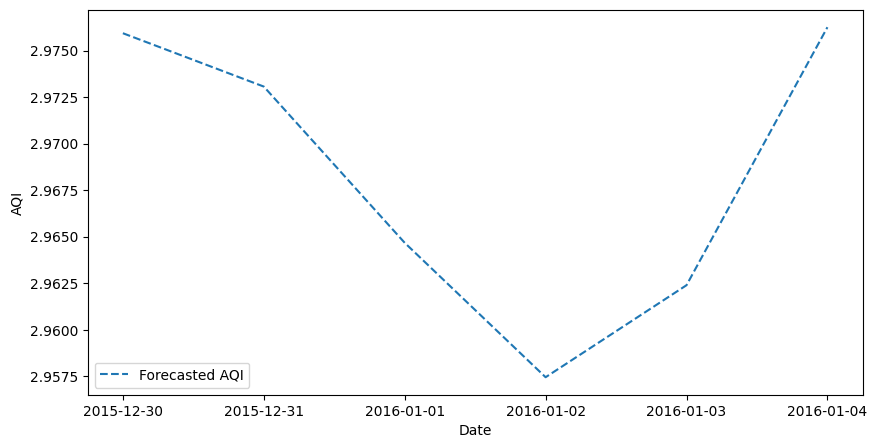

In [105]:
plt.figure(figsize=(10, 5))
# plt.plot(x.index[-3:], x['AQI'].iloc[-3:], label='Actual AQI')  # Dữ liệu AQI thực tế
plt.plot(b.index, b['AQI'], label='Forecasted AQI', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()
